In [30]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
import pandas as pd

from model import FiringRateModel, PolynomialActivation
from evaluate import explained_variance_ratio
from data import get_data, get_train_test_data
from utils import plot_predictions, plot_kernel

pd.set_option('display.max_rows', None)

In [34]:
params = {}
for fname in os.listdir("model/params"):
    with open(f"model/params/{fname}", "rb") as f:
        p = pickle.load(f)
        params[int(fname.split(".")[0])] = p

In [35]:
data = {"cell_id": [], "evr": [], "loss": [], "epochs": []}

for cell_id in params:
    data["cell_id"].append(cell_id)
    data["evr"].append(params[cell_id]["evr"])
    data["loss"].append(params[cell_id]["losses"][-1])
    data["epochs"].append(len(params[cell_id]["losses"]))
    
df = pd.DataFrame(data)
df = df.set_index("cell_id")
df.sort_values("evr")

,evr,loss,epochs
cell_id,,,
464188580,0.000000,4767.731156,3
422055317,0.000000,1541.934966,3
485889190,0.000000,1927.044184,4
480169202,0.000000,2013.742599,3
323838579,0.000000,3695.953425,4
571292875,0.000000,1401.104855,4
567399060,0.000000,1871.379086,3
325464516,0.000000,1086.010318,3
573410831,0.000000,636.777744,3


In [20]:
def load_model(params):
    g = PolynomialActivation()
    g.init_from_params(params["g"])
    model = FiringRateModel(g, [])
    model.init_from_params(params)
    return model

def visualize(cell_id, params, bin_size=20):
    model = load_model(params[cell_id]["params"])
    data = get_data(cell_id, aligned=False)
    Is_tr, fs_tr, Is_te, fs_te, stims = get_train_test_data(data, bin_size)
    
    for Is, fs, s in zip(Is_tr, fs_tr, stims):
        for i in range(Is.shape[0]):
            plot_predictions(
                model, 
                Is[i, :], 
                fs[i, :], 
                cell_id, 
                bin_size, 
                evr = None,
                save = False
            )

    r = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size)
    rq = explained_variance_ratio(model, Is_te[0], fs_te[0], bin_size, quantize=True)
    plot_predictions(
        model, 
        Is_te[0][0, :], 
        fs_te[0][0, :], 
        cell_id, 
        bin_size, 
        evr = (r, rq),
        save = False
    )

    plot_kernel(
        model,
        cell_id,
        bin_size,
        save = False
    )

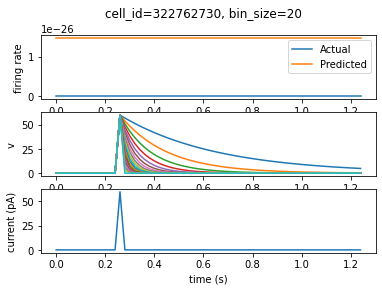

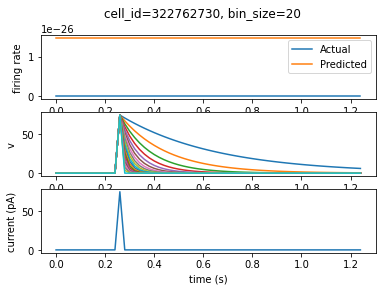

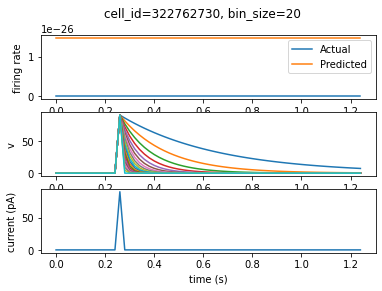

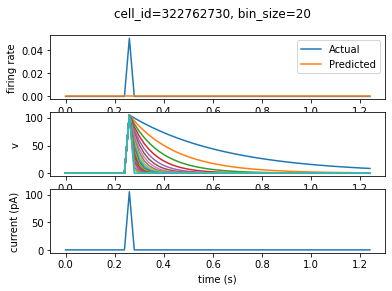

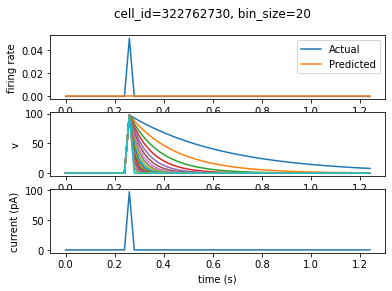

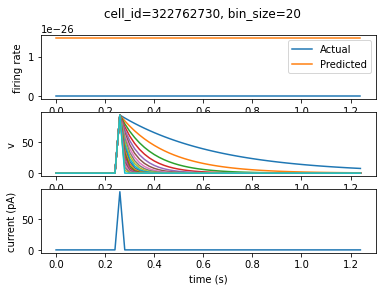

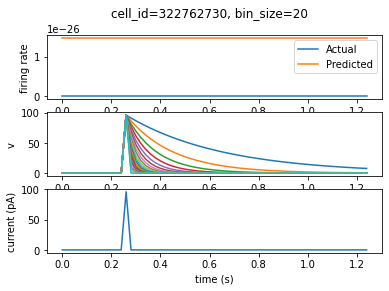

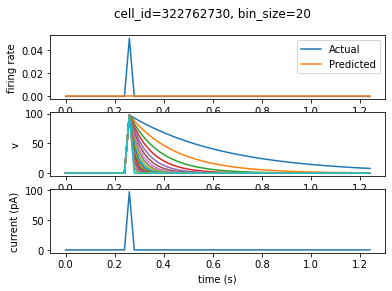

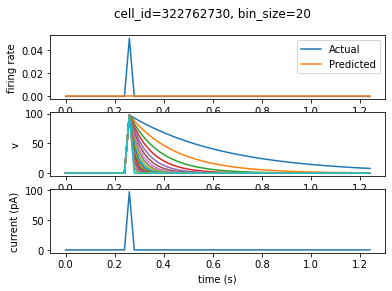

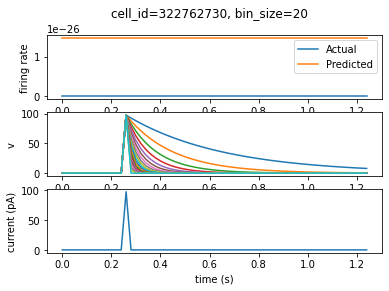

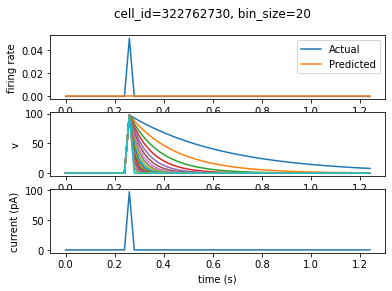

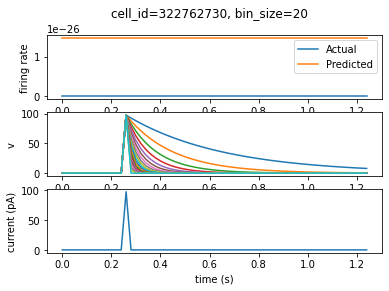

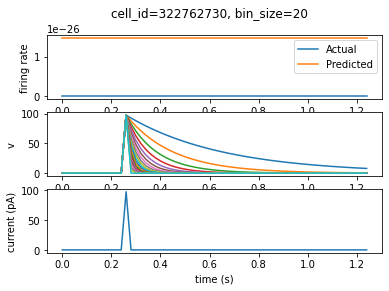

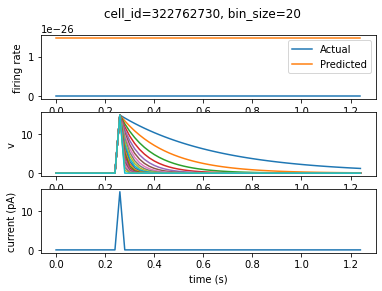

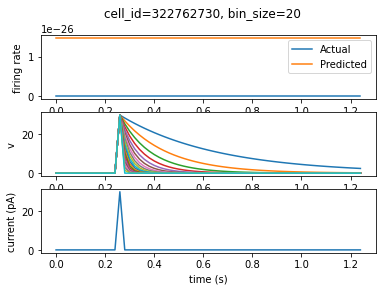

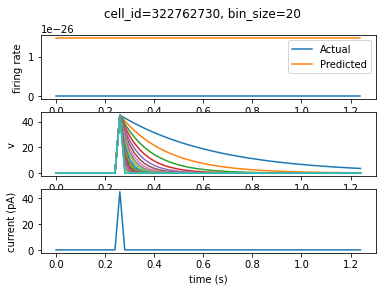

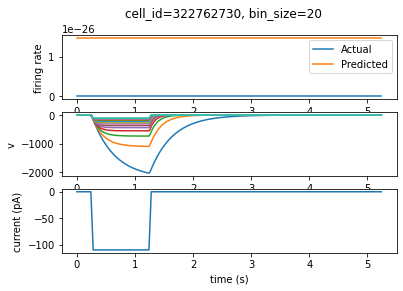

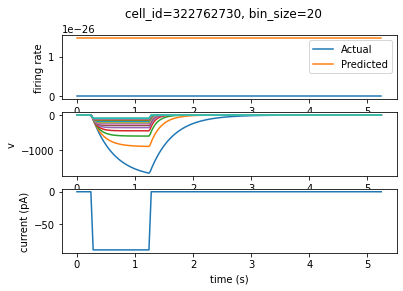

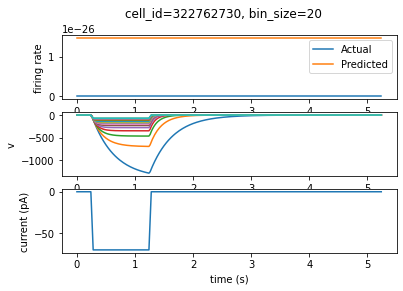

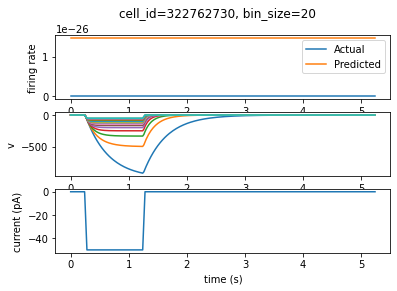

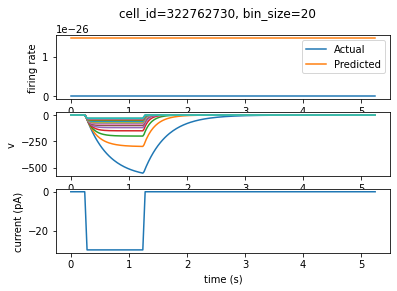

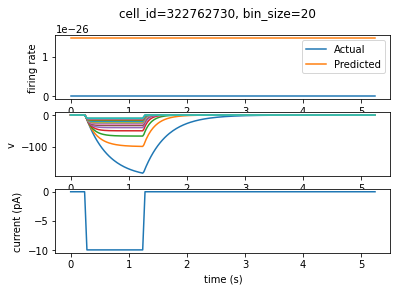

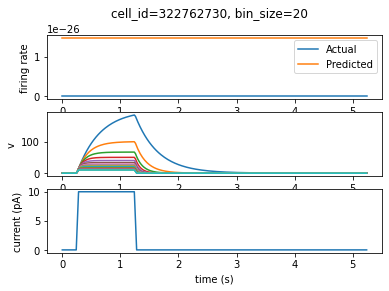

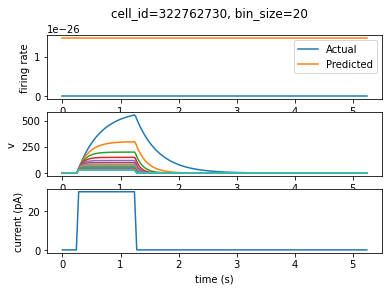

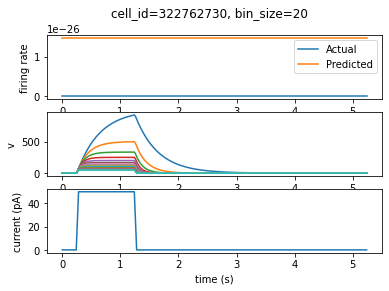

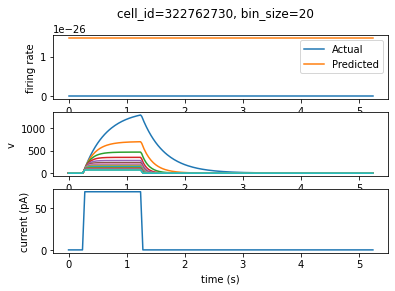

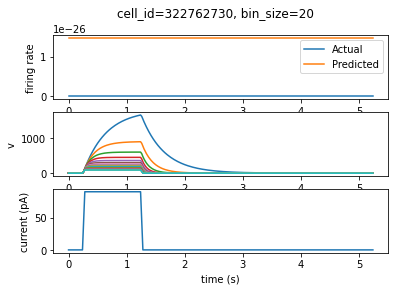

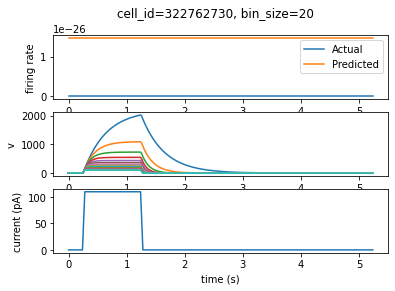

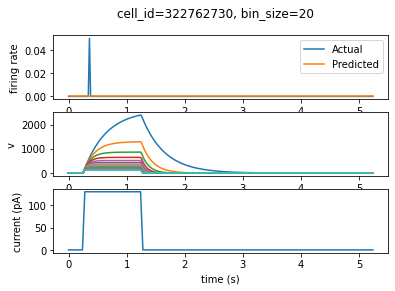

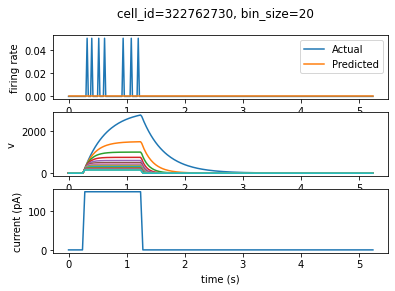

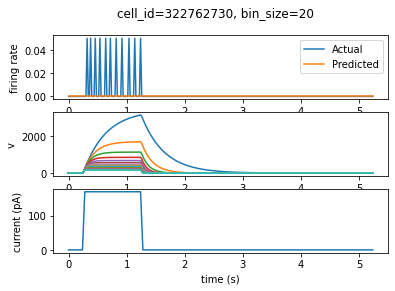

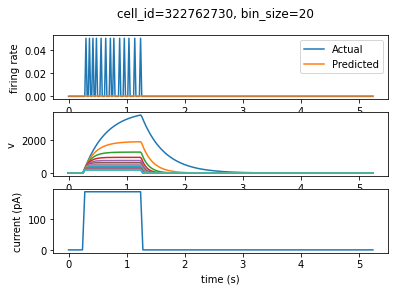

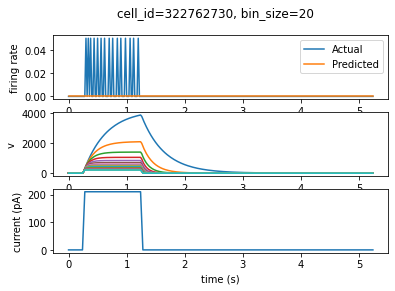

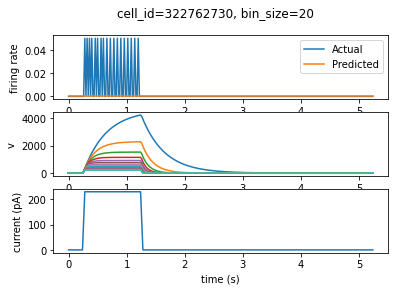

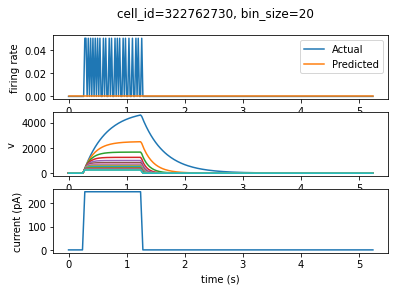

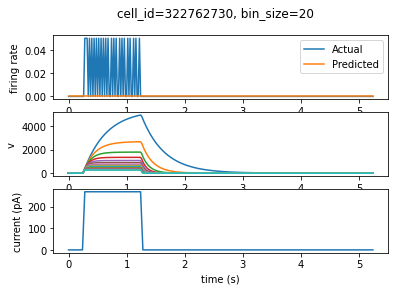

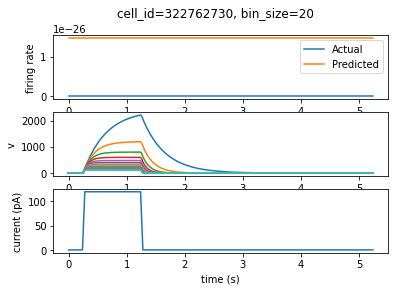

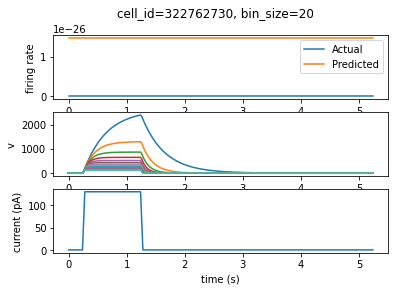

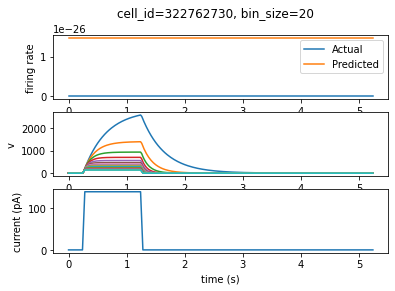

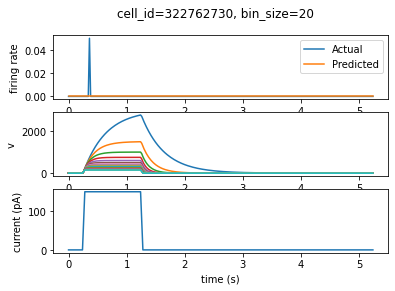

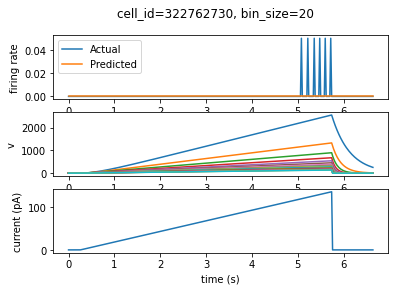

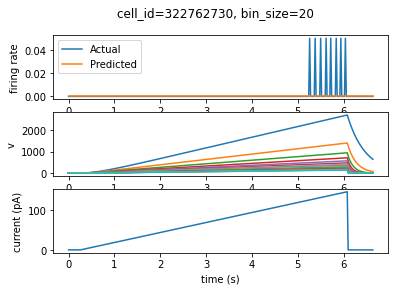

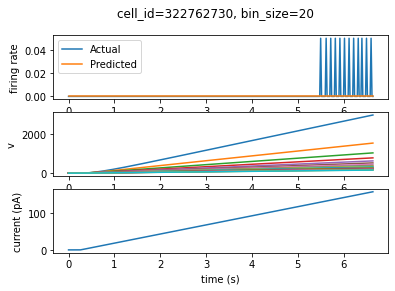

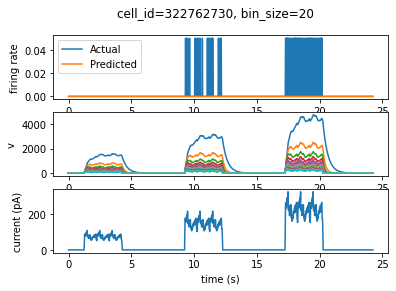

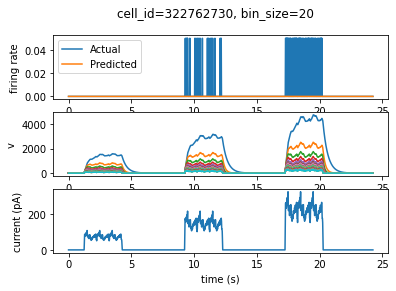

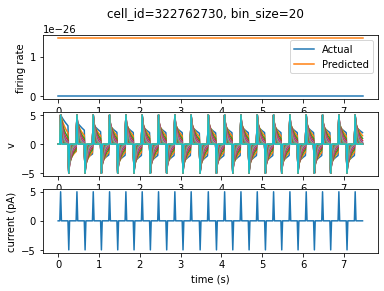

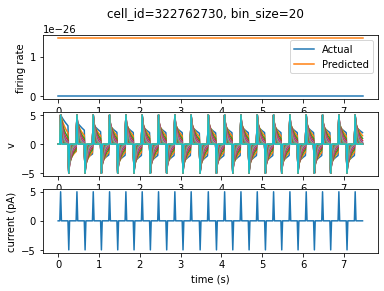

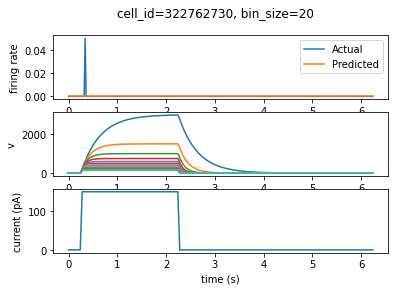

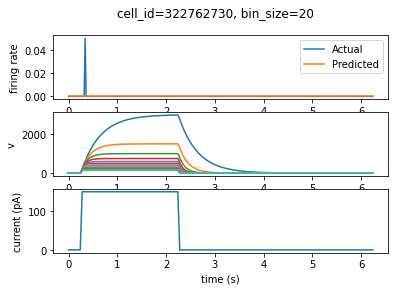

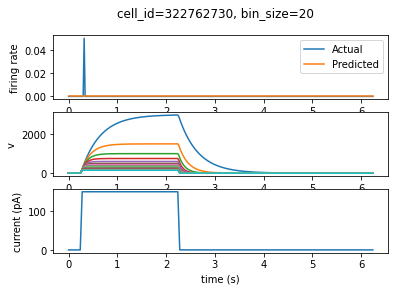

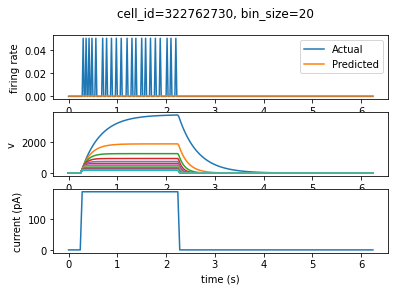

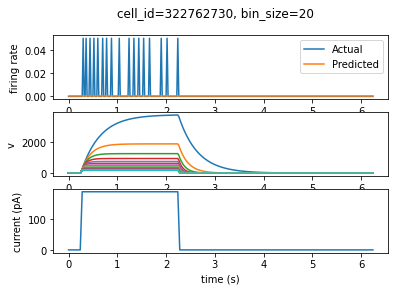

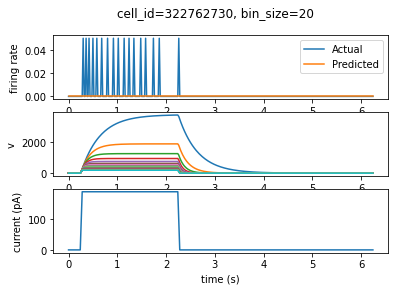

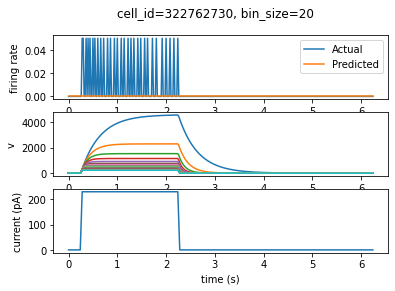

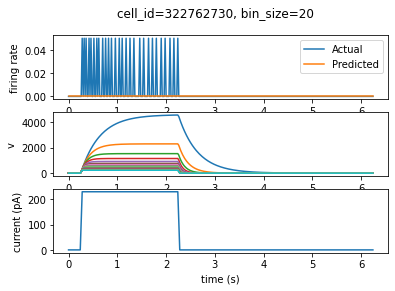

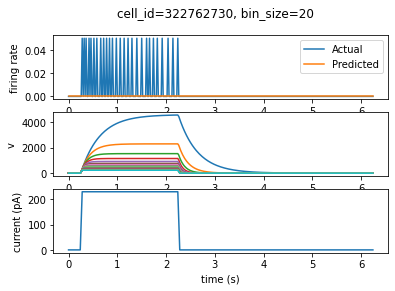

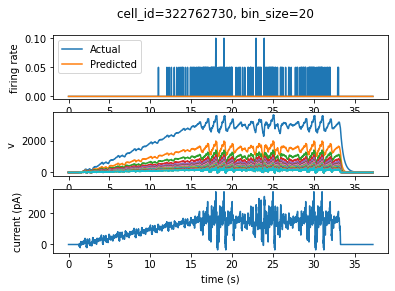

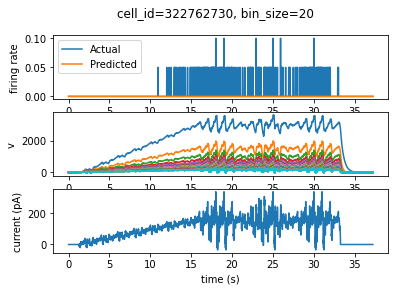

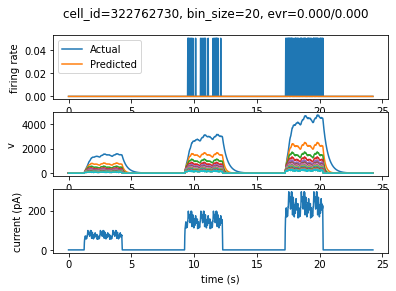

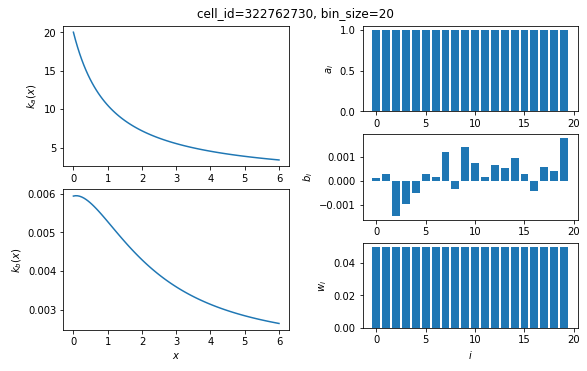

In [33]:
plt.rcParams.update({'figure.max_open_warning': 0})
visualize(322762730, params)